# Training a Classifier

> Author : Badr TAJINI - Machine Learning 2 & Deep learning - ECE 2025-2026

---

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

**What about data?**


Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, Pytorch team has created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


   ![cifar10](https://miro.medium.com/max/1648/1*SZnidBt7CQ4Xqcag6rd8Ew.png)




# How to use Dataset and DataLoader?

## Data Loading

For convenience, PyTorch provides a number of utilities to load, preprocess and interact with datasets. These helper classes and functions are found in the torch.utils.data module. The two major concepts here are:



1.   A Dataset, which encapsulates a source of data,
2.   A DataLoader, which is responsible for loading a dataset, possibly in parallel.



New datasets are created by subclassing the torch.utils.data.Dataset class and overriding the \_\_len__ method to return the number of samples in the dataset and the \_\_getitem__ method to access a single value at a certain index.
​
For example, this would be a simple dataset encapsulating a range of integers:

In [1]:
import math
import torch

class RangeDataset(torch.utils.data.Dataset):
  def __init__(self, start, end, step=1):
    self.start = start
    self.end = end
    self.step = step

  def __len__(self):
    return math.ceil((self.end - self.start) / self.step)

  def __getitem__(self, index):
    value = self.start + index * self.step
    assert value < self.end
    return value

Inside \_\_init__ we would usually configure some paths or change the set of samples ultimately returned.

In \_\_len__, we specify the upper bound for the index with which \_\_getitem__ may be called.

In \_\_getitem__ we return the actual sample, which could be an image or an audio snippet.

In [2]:
dataset = RangeDataset(0, 10, 2)
print(len(dataset))

5


## DataLoader

To iterate over the dataset we could, in theory, simply have a for i in range loop and access samples via \_\_getitem__. However, it would be much more convenient if the dataset implemented the iterator protocol itself, so we could simply loop over samples with for sample in dataset. Fortunately, this functionality is provided by the DataLoader class.

A DataLoader object takes a dataset and a number of options that configure the way samples are retrieved. For example, it is possible to load samples in parallel, using multiple processes. For this, the DataLoader constructor takes a num_workers argument. Note that DataLoaders always return batches, whose size is set with the batch_size parameter. Here is a simple example:



In [3]:
dataset = RangeDataset(0, 9)
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,  # set to True to have the data reshuffled at every epoch
    num_workers=2, # how many subprocesses to use for data loading
    drop_last=True # set to True to drop the last incomplete batch, if the dataset size is not divisible by the batch size.
  )

for i, batch in enumerate(data_loader):
  print(i, batch)

0 tensor([4, 6, 0, 1])
1 tensor([7, 3, 5, 2])


Use an iterator

See details [here](https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset)

In [4]:
dataset_iter = iter(dataset)
print(next(dataset_iter))
print(next(dataset_iter))
print(next(dataset_iter))

0
1
2


# Training an image classifier


We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolutional Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10


Using ``torchvision``, it’s extremely easy to load CIFAR10.




In [5]:
%matplotlib inline

In [6]:
import torch
import torchvision
import torchvision.transforms as transforms

## 1- Load and normalizing the CIFAR10 training and test datasets using ``torchvision``

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:02<00:00, 73.9MB/s]


See the location of the downloaded data

In [8]:
%pwd
%ls -l
%ls -l ./data
%ls -l ./data/cifar-10-batches-py/

total 8
drwxr-xr-x 3 root root 4096 Feb  9 11:17 data/
drwxr-xr-x 1 root root 4096 Jan 16 14:24 sample_data/
total 166508
drwxr-xr-x 2 2156 1103      4096 Jun  4  2009 cifar-10-batches-py/
-rw-r--r-- 1 root root 170498071 Feb  9 11:17 cifar-10-python.tar.gz
total 181876
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


Let us show some of the training images, for fun.



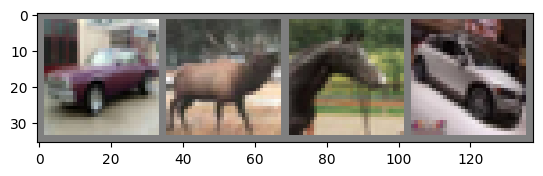

  car  deer horse   car


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2- Define a Convolutional Neural Network


Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



The following neural network is created as a module. This is the best way to create a customized neural network (automatic differentiation is still working)

More information on nn.Module [here](https://pytorch.org/tutorials/beginner/nn_tutorial.html#refactor-using-nn-module)

In [11]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5) #flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

## 3- Define a Loss function and optimizer


Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [12]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4- Train the network



This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



### Question: code the training of the network. Use the autograd mechanism and the optimizer.
Coompute the running loss, i.e., i.e. the average of the loss over N=2000 mini-batches processes.

In [13]:
for epoch in range(5):  # boucle sur le dataset plusieurs fois

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # les données sont une liste de [inputs, labels]
        inputs, labels = data

        # 1. Remettre à zéro les gradients des optimisateurs
        optimizer.zero_grad()

        # 2. Forward pass : calculer la prédiction du réseau
        outputs = net(inputs)

        # 3. Calculer la perte (l'erreur par rapport à la réalité)
        loss = criterion(outputs, labels)

        # 4. Backward pass : calculer l'erreur pour chaque paramètre
        loss.backward()

        # 5. Optimisation : ajuster les poids du réseau
        optimizer.step()

        # Affichage des statistiques
        running_loss += loss.item()
        if i % 2000 == 1999:    # affiche toutes les 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.189
[1,  4000] loss: 1.865
[1,  6000] loss: 1.674
[1,  8000] loss: 1.597
[1, 10000] loss: 1.545
[1, 12000] loss: 1.496
[2,  2000] loss: 1.444
[2,  4000] loss: 1.386
[2,  6000] loss: 1.359
[2,  8000] loss: 1.332
[2, 10000] loss: 1.316
[2, 12000] loss: 1.301
[3,  2000] loss: 1.214
[3,  4000] loss: 1.239
[3,  6000] loss: 1.194
[3,  8000] loss: 1.212
[3, 10000] loss: 1.209
[3, 12000] loss: 1.177
[4,  2000] loss: 1.097
[4,  4000] loss: 1.112
[4,  6000] loss: 1.137
[4,  8000] loss: 1.137
[4, 10000] loss: 1.103
[4, 12000] loss: 1.109
[5,  2000] loss: 1.044
[5,  4000] loss: 1.037
[5,  6000] loss: 1.049
[5,  8000] loss: 1.052
[5, 10000] loss: 1.055
[5, 12000] loss: 1.053
Finished Training


## 5- Test the network on the test data



We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



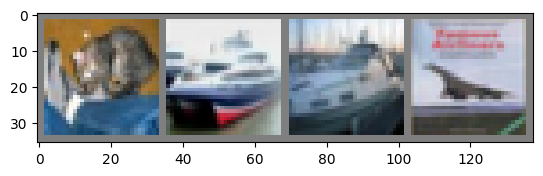

GroundTruth:    cat  ship  ship plane


In [16]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [17]:
outputs = net(images)
print(outputs)

tensor([[-2.3132, -1.2007, -0.0493,  3.3767,  0.2643,  1.4167,  2.9707, -1.7785,
         -0.5758, -2.2704],
        [ 4.6204,  7.3730, -1.2113, -2.6367, -3.7088, -5.5503, -5.5548, -4.5880,
          7.7749,  3.4123],
        [ 3.5305,  5.4042, -0.8920, -2.3769, -2.3069, -3.6125, -3.5806, -3.1078,
          4.6252,  3.1839],
        [ 6.5284,  1.0028, -0.0238, -2.9492, -0.3017, -5.4920, -4.1566, -4.9109,
          5.8121,  2.1990]], grad_fn=<AddmmBackward0>)


The outputs are energies for the 10 classes.
The higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



### Question: give the decision for all the images in the code cell above. The decision should be a label belonging to the object "classes"

In [18]:
# COMPLETE THE CELL FROM HERE
_, predicted = torch.max(outputs, 1)
print('predicted : ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

predicted :    cat  ship   car plane


In [19]:
print(classes)

('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



### Question: compute the average accuracy over all the testset

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # COMPLETE THE CELL FROM HERE
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 61 %


That looks way better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

What are the classes that performed well, and the classes that did
not perform well




### Question: Compute the average accuracy per class (there are 10 classes)

In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # COMPLETE THE CELL FROM HERE
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
          label = labels[i]
          class_correct[label] += c[i].item()
          class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 67 %
Accuracy of   car : 77 %
Accuracy of  bird : 37 %
Accuracy of   cat : 40 %
Accuracy of  deer : 51 %
Accuracy of   dog : 46 %
Accuracy of  frog : 79 %
Accuracy of horse : 67 %
Accuracy of  ship : 72 %
Accuracy of truck : 73 %


In [23]:
''' epochs = 2
Accuracy of plane : 45 %
Accuracy of   car : 68 %
Accuracy of  bird : 46 %
Accuracy of   cat : 35 %
Accuracy of  deer : 52 %
Accuracy of   dog : 53 %
Accuracy of  frog : 52 %
Accuracy of horse : 57 %
Accuracy of  ship : 87 %
Accuracy of truck : 52 %
'''

''' epochs = 5
Accuracy of plane : 66 %
Accuracy of   car : 67 %
Accuracy of  bird : 43 %
Accuracy of   cat : 39 %
Accuracy of  deer : 47 %
Accuracy of   dog : 40 %
Accuracy of  frog : 76 %
Accuracy of horse : 72 %
Accuracy of  ship : 75 %
Accuracy of truck : 81 %
'''

' epochs = 5\nAccuracy of plane : 66 %\nAccuracy of   car : 67 %\nAccuracy of  bird : 43 %\nAccuracy of   cat : 39 %\nAccuracy of  deer : 47 %\nAccuracy of   dog : 40 %\nAccuracy of  frog : 76 %\nAccuracy of horse : 72 %\nAccuracy of  ship : 75 %\nAccuracy of truck : 81 %\n'